In [1]:
import skimage as sk
import numpy as np
import matplotlib.pyplot as plt
from skimage.morphology import ball
from skimage.segmentation import watershed
from skimage.filters import rank, sobel
from scipy import ndimage as ndi
from copy import copy
import tifffile as tiff
import os

In [2]:
# dome = str('32')
folder = './../ppujol/cellstosegment/32_2/tp2/segmentation_2/'
image_route = folder+'t2-interp_denoised-2.tif'
image = sk.io.imread(image_route)

(1086, 450, 531)

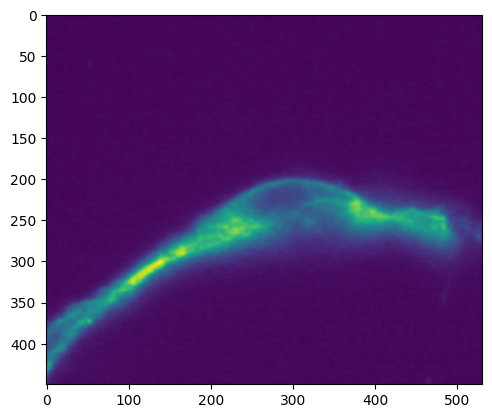

In [5]:
plt.imshow(image[120])
image.shape

In [5]:
def normalize_image(im, mult_factor = 1):
    norm_im = (im - im.min()) / (im.max()-im.min()) * mult_factor
    return norm_im
def reverse_values(im):
    rev_im = im.max()-im
    return rev_im
    

def watershed_get_labels(cell_image, plots=False):
    edges = copy(cell_image)
    edges = ndi.gaussian_filter(edges, 3)
    edges = rank.median(edges, ball(2)) # Can go before the gaussian_filter
    
    edges = normalize_image(edges, 255).astype(np.uint8)
    
    markers = rank.gradient(edges, ball(5)) < 10
    markers = ndi.label(markers)[0]
    labels = watershed(edges, markers) 
    
    
    edt = ndi.distance_transform_edt(edges)
    edt = reverse_values(edt)*edges
    edt = sk.morphology.erosion(edt, footprint=ball(3))
    

    edt = normalize_image(edt, 255).astype(np.uint8)
    markers_edt = rank.gradient(edt, ball(5)) < 10
    markers_edt = ndi.label(markers_edt)[0]
    labels_edt = watershed(cell_image, markers_edt) # INstead of edt we can try with 'edges' Beause we just want the labels
    
    if plots == True:
        delta = 150
        plt.figure(figsize=(15,15))
        plt.subplot(221)
        plt.imshow(edges[delta])
        plt.subplot(222)
        plt.imshow(labels[delta])
        plt.subplot(223)
        plt.imshow(edt[delta])
        plt.subplot(224)
        plt.imshow(labels_edt[delta])
        
    return labels_edt


def watershed_get_labels_sobel(cell_image, plots=False):
    edges = copy(cell_image)
    edges = ndi.gaussian_filter(edges, 1)
    edges = rank.median(edges, ball(2)) # Can go before the gaussian_filter
    
    edges = normalize_image(edges, 255).astype(np.uint8)
    
    markers = rank.gradient(edges, ball(5)) < 10
    markers = ndi.label(markers)[0]
    labels = watershed(edges, markers) 
    
    
    edt = ndi.distance_transform_edt(edges)
    edt = reverse_values(edt)*edges
    edt = sk.morphology.erosion(edt, footprint=ball(3))
    

    edt = normalize_image(edt, 255).astype(np.uint8)
    markers_edt = rank.gradient(edt, ball(5)) < 10
    markers_edt = ndi.label(markers_edt)[0]
    labels_edt = watershed(edt, markers_edt) # INstead of edt we can try with 'edges' Beause we just want the labels
    
    if plots == True:
        delta = 150
        plt.figure(figsize=(25,25))
        plt.subplot(221)
        plt.imshow(edges[delta])
        plt.subplot(222)
        plt.imshow(labels[delta])
        plt.subplot(223)
        plt.imshow(edt[delta])
        plt.subplot(224)
        plt.imshow(labels_edt[delta])
        
    return labels_edt, edt, labels, edges


def plot_labels_indeces(labels_edt):
    plt.figure(figsize=(25,25))
    for i in range(9):
        slice = int(labels_edt.shape[0]/17)*(i+4)
    
        temp_labels = copy(labels_edt[slice])
        intensities = {}
        unique_temp_labels = np.unique(temp_labels)
        for temp_label in unique_temp_labels:
            temp_temp_label = copy(temp_labels)
            temp_temp_label[temp_temp_label != temp_label] = 0
            center = ndi.center_of_mass(temp_temp_label)
            intensities[temp_label] = center
    
        intensities = {k: (int(v[0]), int(v[1])) for k, v in intensities.items() if not any(np.isnan(coord) for coord in v)}
    
        plt.subplot(3,3,i+1)
        plt.imshow(temp_labels)
        plt.title(f"Slice {slice}")
    
        for center in intensities:
            center = intensities[center]
            plt.text(center[1], center[0], f'{temp_labels[int(center[0]), int(center[1])]}', ha='center', va='center', color='red')


def cell_mask(labels, labels_indices):
    d3_masked_image = copy(labels)
    mask_complete = np.isin(d3_masked_image, labels_indices)
    d3_masked_image[~mask_complete] =  0
    d3_masked_image[d3_masked_image!=0] = 1
    d3_masked_image = sk.morphology.binary_closing(d3_masked_image, footprint=sk.morphology.ball(5))
    d3_masked_image = d3_masked_image.astype(np.uint8)
    return d3_masked_image


def write_image(route, array):
    tiff.imwrite(route, array.astype(np.uint16), imagej=True)
    print(f"Saved to {route}")

(400, 400, 400)

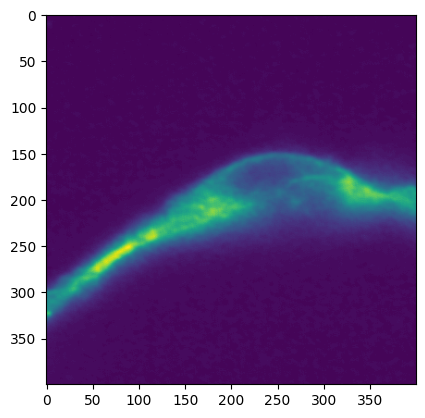

In [78]:
z, y, x = 516, 250, 250
delta = 200
division = 1
cell = image[z-int(delta/division):z+int(delta/division), y-delta:y+delta, x-delta:x+delta]
cell = normalize_image(cell, 255).astype(np.uint8)
plt.imshow(cell[int(delta/division)])
cell.shape

In [79]:
labels_cell = watershed_get_labels(cell)

In [2]:
# plot_labels_indeces(labels_cell)

In [81]:
route_image = folder+'image_used.tif'
write_image(route=route_image, array=cell)
route_labels = folder+'labels_cell.tif'
write_image(route=route_labels, array=labels_cell)

Saved to ./../ppujol/cellstosegment/32_2/tp2/segmentation_2/image_used.tif
Saved to ./../ppujol/cellstosegment/32_2/tp2/segmentation_2/labels_cell.tif


In [82]:
label_numbers = []
mask = cell_mask(labels_cell, label_numbers)

In [83]:
route_segmentation = folder+'segmented_cell.tif'
write_image(route=route_segmentation, array=mask)

Saved to ./../ppujol/cellstosegment/32_2/tp2/segmentation_2/segmented_cell.tif


In [64]:
route_document = folder
name_document = 'segment_file-v1.txt'
file_path = route_document + name_document
version =  2

while os.path.exists(file_path):
    # Split the name and extension
    name, ext = os.path.splitext(name_document)
    name = name.split('-')
    print(name)
    name_document = f"{name[0]}-v{version}{ext}"
    # Update the file path with the new name
    file_path = route_document + name_document
    # Increment the version number
    version +=  1

# Now, write to the file
with open(file_path, 'w') as file:
    file.write(f"#Inner cell labels\n")
    file.write(f"image_route = {image_route}\n")
    file.write(f"segmentation_route = {route_segmentation}\n")
    file.write(f"used_image_route = {route_image}\n")
    file.write(f"all the inner labels image = {route_labels}\n")
    file.write(f"z, y, x = {z, y, x}\n")
    file.write(f"delta = {delta}\n")
    file.write(f"division = {division}\n")
    file.write(f"label_numbers = {label_numbers}\n")
        

print(f"Saved document as v{version-1}")

Saved document as v1


## Now its time to do something with the borders....

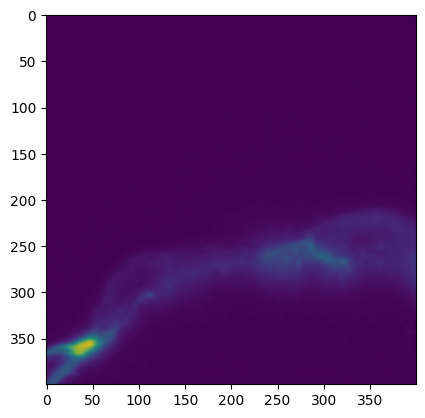

In [84]:
plt.imshow(mask[120])
plt.imshow(cell[120], alpha=0.8)

# Testing part

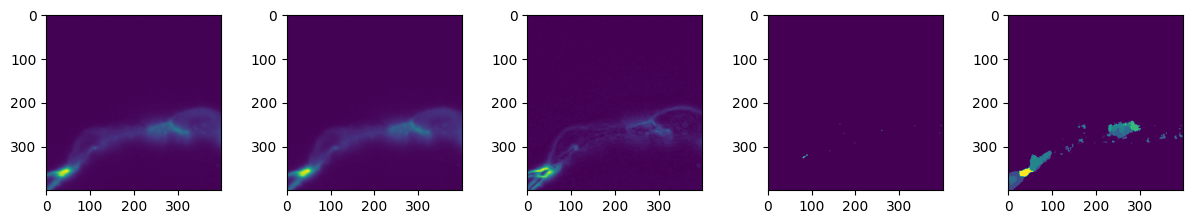

In [85]:
def detect_borders(cell, inner_mask):
    y = 120
    
    plt.figure(figsize=(15,5))
    plt.subplot(251)
    plt.imshow(cell[y])
    
    denoised = rank.median(cell, ball(2))
    
    plt.subplot(252)
    plt.imshow(denoised[y])

    gradient = rank.gradient(denoised, ball(2))

    plt.subplot(253)
    plt.imshow(gradient[y])

    markers = rank.gradient(denoised, ball(5)) < 10
    markers = ndi.label(markers)[0]

    ## Remove the markers where we have the inner mask and place that instead.
    unique_intersection = np.unique(markers[inner_mask != 0])
    unique_intersection = unique_intersection[unique_intersection != 0]
    # markers[np.isin(markers, unique_intersection)] = markers.max() + 1
    markers[inner_mask != 0] = markers.max() + 1
    
    plt.subplot(254)
    plt.imshow(markers[y])
    
    labels = watershed(gradient, markers)

    plt.subplot(255)
    plt.imshow(labels[y])

    ## Now we will expand the first mask to get more labels from the border mask
    inner_mask = sk.morphology.binary_dilation(inner_mask, footprint=ball(3))
    unique_intersection = np.unique(labels[inner_mask != 0])
    unique_intersection = unique_intersection[unique_intersection != 0]
    # markers[np.isin(markers, unique_intersection)] = markers.max() + 1
    labels[inner_mask != 0] = labels.max() + 1
    
    
    
    return labels


labels_gradient = detect_borders(cell, mask)

In [1]:
# plot_labels_indeces(labels_gradient)
# plot_labels_indeces(np.transpose(labels_gradient, axes=(1,0,2)))
# plot_labels_indeces(np.transpose(labels_gradient, axes=(0,2,1)))

In [87]:
route_labels_borders = folder+'labels_border_cell.tif'
write_image(route=route_labels_borders, array=labels_gradient)

Saved to ./../ppujol/cellstosegment/32_2/tp2/segmentation_2/labels_border_cell.tif


In [71]:
label_gradient_numbers = [391, 390]
mask_gradient = cell_mask(labels_gradient, label_gradient_numbers)

In [72]:
route_border_segmentation = folder+'segmented_borders_cell.tif'
write_image(route=route_border_segmentation, array=mask_gradient)

Saved to ./../ppujol/cellstosegment/355/second_try/segmented_borders_cell.tif


In [21]:
name_document = f'segment_file-v{version-1}.txt'
file_path = route_document + name_document

with open(file_path, 'a') as file:
    file.write(f"#Outer cell labels\n")
    file.write(f"segmented_labels_route = {route_border_segmentation}\n")
    file.write(f"all_labels_borders_route = {route_labels_borders}\n")
    file.write(f"label_gradient_numbers = {label_gradient_numbers}\n")



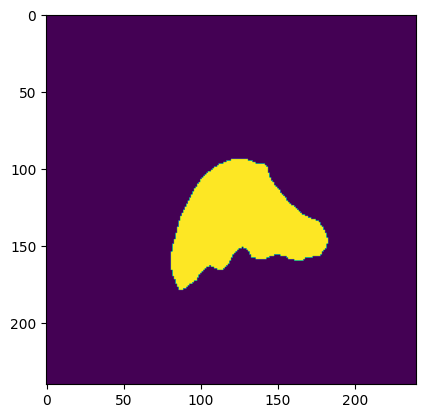

In [136]:
plt.imshow(sk.morphology.binary_erosion(sk.morphology.binary_opening(mask_gradient, ball(3)), ball(1))[120])
# plt.imshow(sobel(cell[120]), alpha=0.8)